# クラス分類に関しての疑問を試してみる
- imbalanced dataに対してdown sampling(up sampling)したときにAUCは改善する？(最近のkaggleでauc多い。。)
- 2値分類で、CLassifier　でなく Regressionを使った際は精度変わる？(toxicやった時、一部の学習器でreg>clfになった。誤差レベルだけど)

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor, ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix

In [2]:
def my_plot(true_label, pred_proba):
    print('auc : ', roc_auc_score(true_label, pred_proba))
    fpr, tpr, thresholds = roc_curve(y_va, pred_va_proba, pos_label=1)
    plt.plot(fpr, tpr)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title("ROC curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

In [3]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    plt.show()

In [4]:
# mean_ar1 = [0, 0]
# std_ar1 = [[10, 0], [0, 10]]
# mean_ar2 = [5, 5]
# std_ar2 = [[3, 0], [0, 3]]
# #mean_ar2 = [0, 0]
# #std_ar2 = [[10, 0], [0, 10]]
n_tr1 = 50000
n_tr2 = 100
X1 = stats.uniform.rvs(-3, 6, (n_tr1, 2))
X2 = stats.uniform.rvs(-1, 2, (n_tr2, 2))

# X1 = np.random.multivariate_normal(mean_ar1, std_ar1, n_tr1)
# X2 = np.random.multivariate_normal(mean_ar2, std_ar2, n_tr2)
y1 = np.zeros(n_tr1)
y2 = np.ones(n_tr2)

X = np.vstack([X1, X2])
y = np.vstack([y1.reshape(-1, 1), y2.reshape(-1, 1)]).reshape(-1)
#data = np.hstack([np.vstack([X1, X2]), np.vstack([y1.reshape(-1, 1), y2.reshape(-1, 1)])])
#np.random.shuffle(data)

imbalance datanのロード(dataはtjoさんのimbalanceクラス分類の記事から)

In [5]:
data = np.loadtxt('Book1.csv', skiprows=1, delimiter=',')
X = data[:, :2]
y = data[:, -1]

target = 1 : 250
target = 0 : 3750


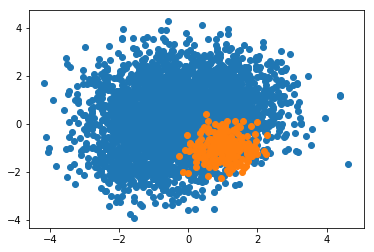

In [6]:
print('target = 1 :', sum(y==1))
print('target = 0 :', sum(y==0))
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])
plt.show()

Train:Val = 0.8:0.2で適当にfitting

In [7]:
X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=71)
print(f'tr_pos : {int(sum(y_tr))}')
print(f'tr_neg : {int(len(y_tr)-sum(y_tr))}')
print(f'va_pos : {int(sum(y_va))}')
print(f'va_neg : {int(len(y_va)-sum(y_va))}')


tr_pos : 190
tr_neg : 3010
va_pos : 60
va_neg : 740


# ベースの予測モデル(てきとーにfitting)

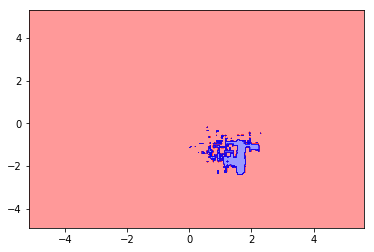

In [8]:
clf = RandomForestClassifier(100, random_state=71)
clf.fit(X_tr, y_tr)
pred_va = clf.predict(X_va)
plot_decision_regions(X, y, clf)
pred_va_proba = clf.predict_proba(X_va)[:, 1]

テキトーなfittingした分類器の予測。

In [9]:
def my_plot(true_label, pred_proba):
    print('auc : ', roc_auc_score(true_label, pred_proba))
    fpr, tpr, thresholds = roc_curve(y_va, pred_va_proba, pos_label=1)
    plt.plot(fpr, tpr)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title("ROC curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

auc :  0.876959459459


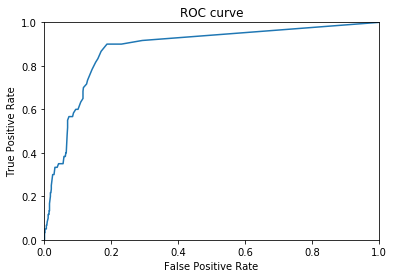

In [10]:
my_plot(y_va, pred_va_proba)

最初の方はうまく予測できている？(実は予測できていない、rocがうまくいってるように見えるのは、Negの数が圧倒的に多く、絶対にPosじゃないってやつが大部分で、それらをNegって予測してたらこんな風に左に曲線が寄ったプロットになる。)
途中からほぼ(1, 1)に向かう直線になっている。クラスターから少し離れてぽつんとなっているPosとNegを判別できてない

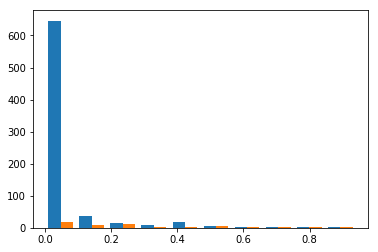

(0, 50)

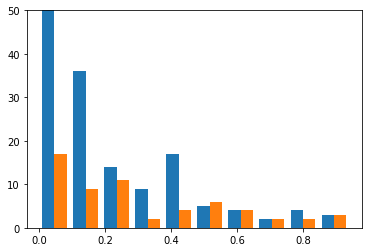

In [11]:
plt.hist((pred_va_proba[y_va==0], pred_va_proba[y_va==1]), bins=10)
plt.show()
plt.hist((pred_va_proba[y_va==0], pred_va_proba[y_va==1]), bins=10)
plt.ylim(0, 50)

AUCがいいと、PosっぽいものはちゃんとPosっぽく、NegっぽいものはちゃんとNegっぽく予測するものだと思ってたけど、imbalance dataだとそうでもない。
(確実にNegのものを当てられたらAUCよくなるから)

proba>0.01
0.688488195798

probaが0.01未満のサンプル
Pos : 5
Neg : 523


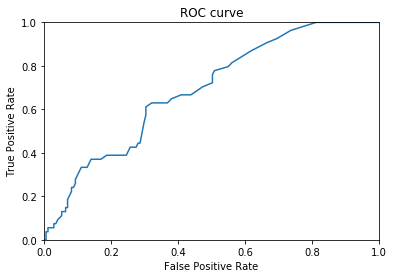

In [12]:
threshold = 0.01
print(f'proba>{threshold}')
print(roc_auc_score(y_va[pred_va_proba>threshold], pred_va_proba[pred_va_proba>threshold]))
print()
print(f'probaが{threshold}未満のサンプル\n'
     f'Pos : {int(sum(y_va[pred_va_proba<threshold]))}\n'
     f'Neg : {int(len(y_va[pred_va_proba<threshold])-sum(y_va[pred_va_proba<threshold]))}')
fpr, tpr, thresholds = roc_curve(y_va[pred_va_proba>threshold], pred_va_proba[pred_va_proba>threshold], pos_label=1)
plt.plot(fpr, tpr)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

ある程度以上のprobaを持つものについてはあまりよく予測できていない。(imbalance dataでの評価指標としてaucは妥当なのか？？)

# Sample weight

決定木系でsample weight使うのあんま意味ないと思う(そもそもノードの分割の時に割合ベースでやってるから))
ほんとか？

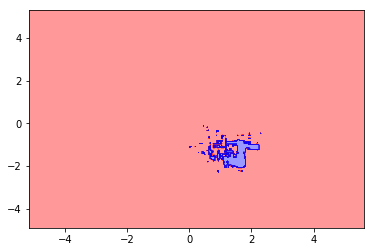

In [13]:
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=71)
clf.fit(X_tr, y_tr)
pred_va = clf.predict(X_va)
plot_decision_regions(X, y, clf)

auc :  0.879684684685


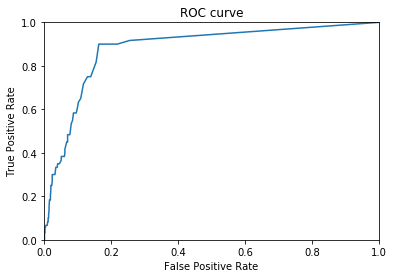

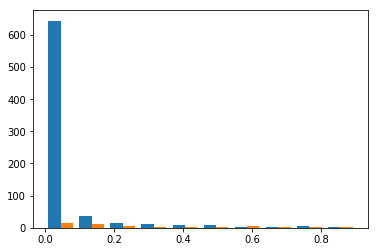

(0, 50)

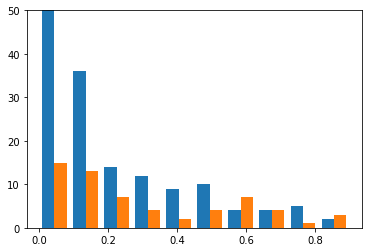

In [14]:
pred_va_proba = clf.predict_proba(X_va)[:, 1]
my_plot(y_va, pred_va_proba)
plt.hist((pred_va_proba[y_va==0], pred_va_proba[y_va==1]), bins=10)
plt.show()
plt.hist((pred_va_proba[y_va==0], pred_va_proba[y_va==1]), bins=10)
plt.ylim(0, 50)

ほぼ意味なかった

# Down Sampling

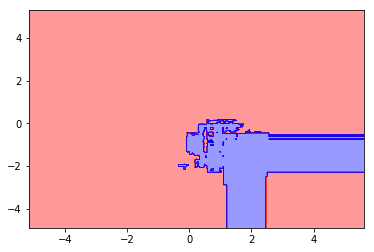

In [15]:
X_tr_pos = X_tr[y_tr==1]
X_tr_neg = X_tr[y_tr==0]
y_tr_pos = np.ones(len(X_tr_pos))
y_tr_neg = np.zeros(len(X_tr_neg))
np.random.seed(71)
np.random.shuffle(X_tr_neg)
n_neg_tr = len(X_tr_pos)
X_tr_ds = np.vstack([X_tr_pos, X_tr_neg[:n_neg_tr]])
y_tr_ds = np.vstack([y_tr_pos.reshape(-1, 1), y_tr_neg[:n_neg_tr].reshape(-1, 1)]).reshape(-1)
clf = RandomForestClassifier(100, random_state=71)
clf.fit(X_tr_ds, y_tr_ds)
pred_va = clf.predict(X_va)
plot_decision_regions(X, y, clf)

auc :  0.899617117117


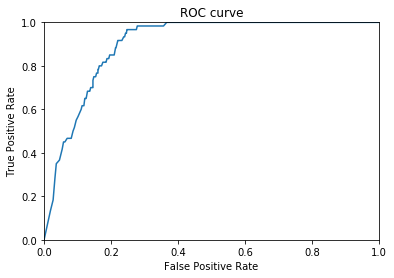

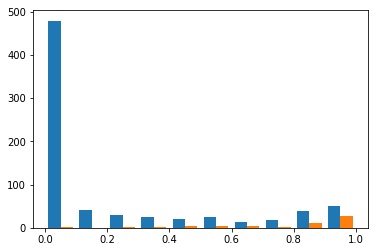

(0, 50)

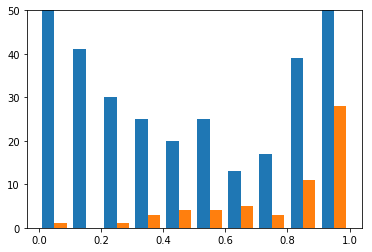

In [16]:
pred_va_proba = clf.predict_proba(X_va)[:, 1]
my_plot(y_va, pred_va_proba)
plt.hist((pred_va_proba[y_va==0], pred_va_proba[y_va==1]), bins=10)
plt.show()
plt.hist((pred_va_proba[y_va==0], pred_va_proba[y_va==1]), bins=10)
plt.ylim(0, 50)

aucの値はあんま変わってないけど、ROC_curveがかなり変わった。
だいたんにPos予測するから取り逃して、FalsePosに埋もれるPosがなくなったのかな

# Down Sampling + Bagging

In [17]:
def ds_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    plt.show()
    return Z

In [18]:
def ds_plot_decision_regions(X, y, Z, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    plt.show()

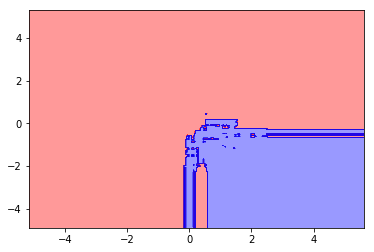

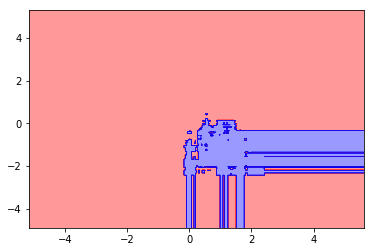

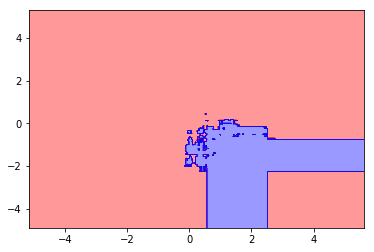

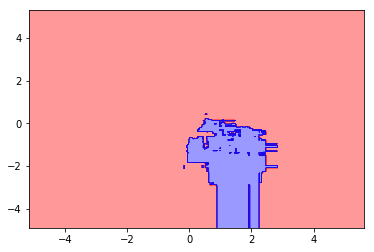

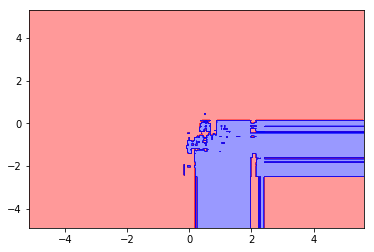

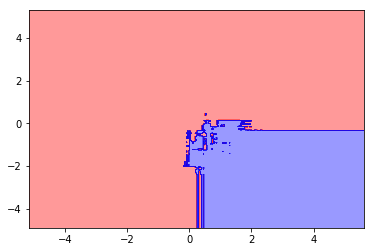

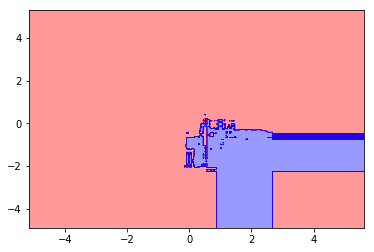

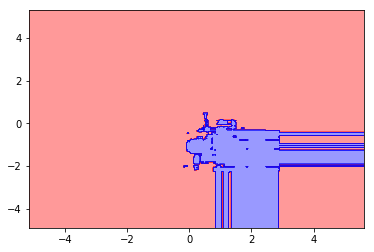

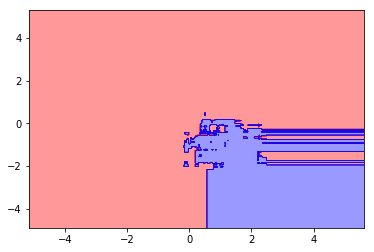

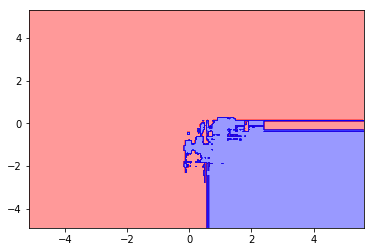

In [19]:
n_bagging = 10
preds_proba = np.zeros([len(X_va), n_bagging])
Z = []
for i in range(n_bagging):
    np.random.seed(i)
    np.random.shuffle(X_tr_neg)
    n_neg_tr = len(X_tr_pos)
    X_tr_ds = np.vstack([X_tr_pos, X_tr_neg[:n_neg_tr]])
    y_tr_ds = np.vstack([y_tr_pos.reshape(-1, 1), y_tr_neg[:n_neg_tr].reshape(-1, 1)]).reshape(-1)
    clf = RandomForestClassifier(100, random_state=i)
    clf.fit(X_tr_ds, y_tr_ds)
    preds_proba[:, i] = clf.predict_proba(X_va)[:, 1]
    Z.append(ds_decision_regions(X, y, clf))
preds_proba = preds_proba.mean(axis=1)

auc :  0.906846846847


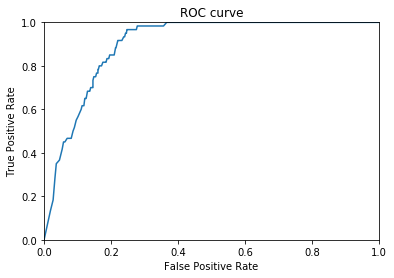

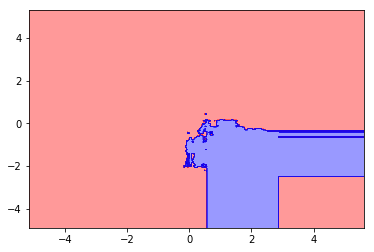

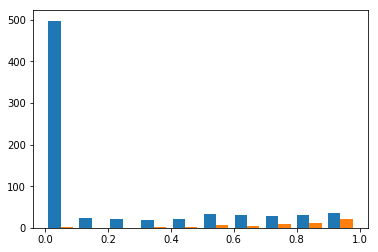

(0, 50)

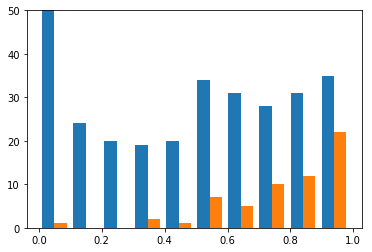

In [20]:
my_plot(y_va, preds_proba)
a = Z[0]
for i in range(1, len(Z)):
    a += Z[i]
a /= n_bagging
a[a<0.5] = 0
a[a>=0.5] = 1
ds_plot_decision_regions(X, y, a)
plt.hist((preds_proba[y_va==0], preds_proba[y_va==1]), bins=10)
plt.show()
plt.hist((preds_proba[y_va==0], preds_proba[y_va==1]), bins=10)
plt.ylim(0, 50)

イイ感じにauc上がった。
down samplingするとNeg側からとってくるところ偏るからensembleで補う感じ

# RFclfの代わりにRFregをつかってみる

In [21]:
def plot_decision_regions_for_reg(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z[Z<0.5] = 0
    Z[Z>=0.5] = 1
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    plt.show()

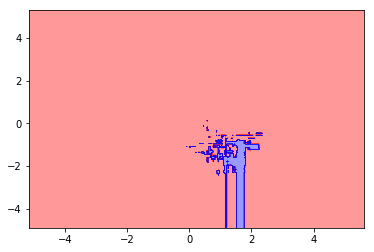

auc :  0.86606981982


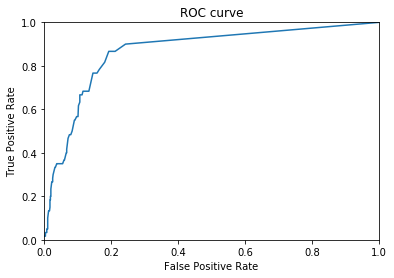

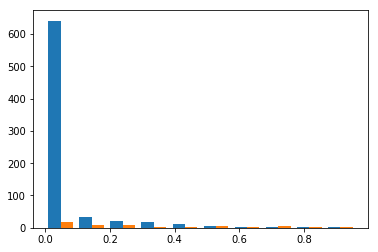

(0, 50)

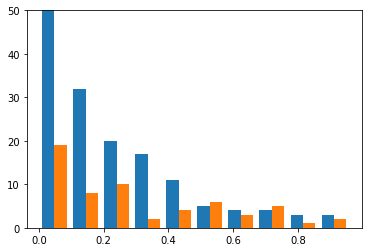

In [22]:
clf = RandomForestRegressor(100, random_state=71)
clf.fit(X_tr, y_tr)
pred_va_proba = clf.predict(X_va)
plot_decision_regions_for_reg(X, y, clf)
my_plot(y_va, pred_va_proba)
plt.hist((pred_va_proba[y_va==0], pred_va_proba[y_va==1]), bins=10)
plt.show()
plt.hist((pred_va_proba[y_va==0], pred_va_proba[y_va==1]), bins=10)
plt.ylim(0, 50)

評価関数が違うからやっぱだめっぽい

# ベース+Bagging

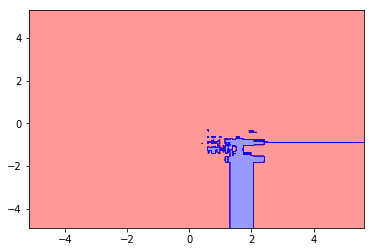

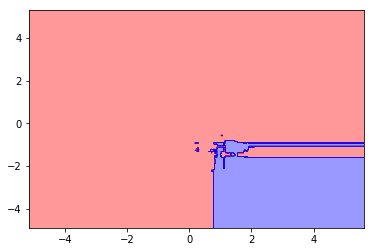

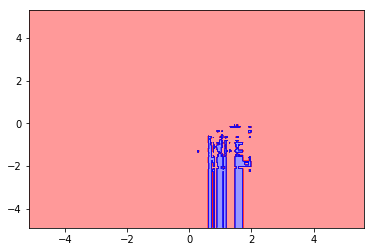

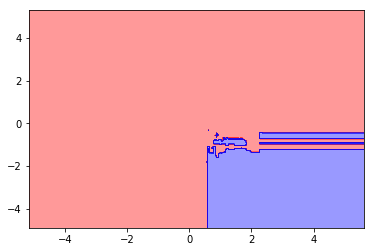

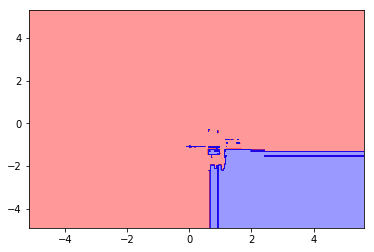

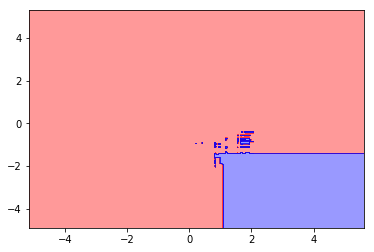

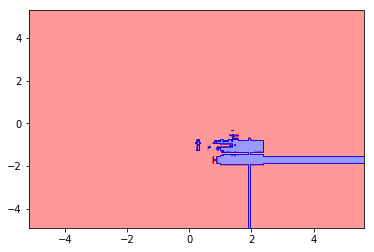

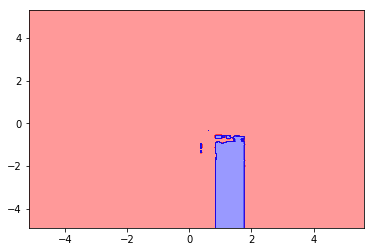

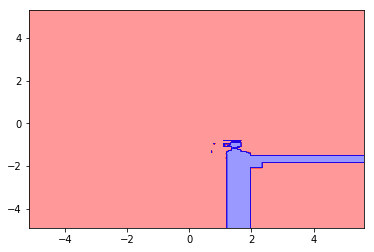

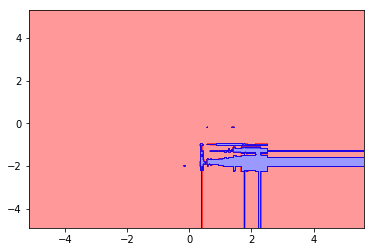

In [23]:
n_bagging = 10
preds_proba = np.zeros([len(X_va), n_bagging])
Z = []
data = np.hstack([X_tr, y_tr.reshape(-1, 1)])
for i in range(n_bagging):
    np.random.seed(i)
    np.random.shuffle(data)
    X_tr_bg = data[:380, :2]
    y_tr_bg = data[:380, 2]
    clf = RandomForestClassifier(100, random_state=i)
    clf.fit(X_tr_bg, y_tr_bg)
    preds_proba[:, i] = clf.predict_proba(X_va)[:, 1]
    Z.append(ds_decision_regions(X, y, clf))
preds_proba = preds_proba.mean(axis=1)

auc :  0.895315315315


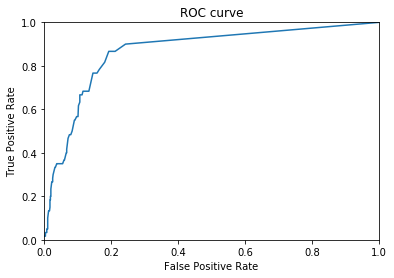

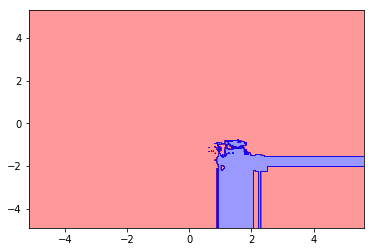

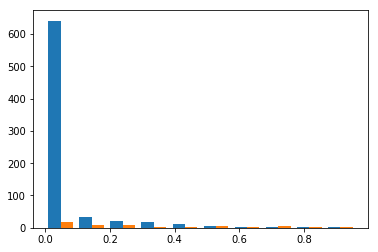

(0, 50)

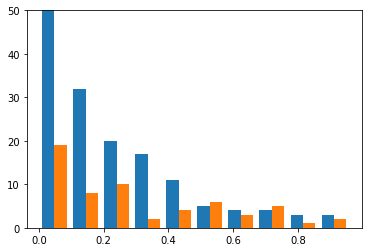

In [24]:
my_plot(y_va, preds_proba)
a = Z[0]
for i in range(1, len(Z)):
    a += Z[i]
a /= n_bagging
a[a<0.5] = 0
a[a>=0.5] = 1
ds_plot_decision_regions(X, y, a)
plt.hist((pred_va_proba[y_va==0], pred_va_proba[y_va==1]), bins=10)
plt.show()
plt.hist((pred_va_proba[y_va==0], pred_va_proba[y_va==1]), bins=10)
plt.ylim(0, 50)

# まとめ

- Down Sampling + BaggingでもAUC改善した
- あんま直感的に理解できてない
- あたまがわるい
- imbalanceでauc評価値微妙じゃねって思った。1sampleずつ予測体調が来るようなオンラインでの予測には向かなそう?だし
- けど結局何のために予測したいかとか次第なのかな？
- 最近のkaggleだとimbalanceでauc多い気がするし。
- じつむってどんななんや。。
- 他も試せよ。()

あとでやる:実験追加, 汚いのできれいになおす(なおさない) ..

参考(というかほぼそのまま):
- https://tjo.hatenablog.com/entry/2017/08/11/162057